In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_final = pd.read_csv("final_output.csv")
df_final

,created_at,state,apmc,commodity,min_price,modal_price,max_price,commodity_arrivals,commodity_traded,year,month,day
0,2021-01-01,RAJASTHAN,SAWAI MADHOPUR,URAD (BLACK GRAM),61.55,65.0,65.55,4100.0,4100.0,2021,1,1
1,2021-01-01,RAJASTHAN,SIKAR,GINGER,20.00,20.0,20.00,400.0,400.0,2021,1,1
2,2021-01-01,RAJASTHAN,RAJSAMAND,SPINACH (PALAK),8.00,8.0,8.00,600.0,400.0,2021,1,1
3,2021-01-01,RAJASTHAN,RAJSAMAND,FENUGREEK (HARI METHI),7.50,8.0,8.00,500.0,400.0,2021,1,1
4,2021-01-01,RAJASTHAN,RAJSAMAND,BRINJAL,19.00,20.0,20.00,500.0,400.0,2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3202290,2025-09-06,ODISHA,BARIPADA,RIDGE GOURD (TURAI),40.00,40.0,40.00,1600.0,1600.0,2025,9,6
3202291,2025-09-06,ODISHA,BARIPADA,BOTTLE GOURDE,20.00,20.0,20.00,1600.0,1600.0,2025,9,6
3202292,2025-09-06,HARYANA,SOHNA,ONION,17.00,18.0,20.00,1600.0,1600.0,2025,9,6
3202293,2025-09-06,HARYANA,SIRSA,ARBI (COLACASIA),21.00,28.0,28.00,1600.0,1600.0,2025,9,6


In [3]:
df_final['created_at'] = pd.to_datetime(df_final['created_at'])
df_final = df_final.set_index('created_at').sort_index()

## Time series

In [4]:
def create_time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week
    return df

[0]	validation_0-mae:3.04324	validation_1-mae:7.83252
[75]	validation_0-mae:0.19191	validation_1-mae:7.42919

Model's Mean Absolute Error on the Test Set: 7.41
R-squared (R²): 0.16


C:\Users\WELCOME\AppData\Local\Temp\ipykernel_7036\1627085486.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = predictions


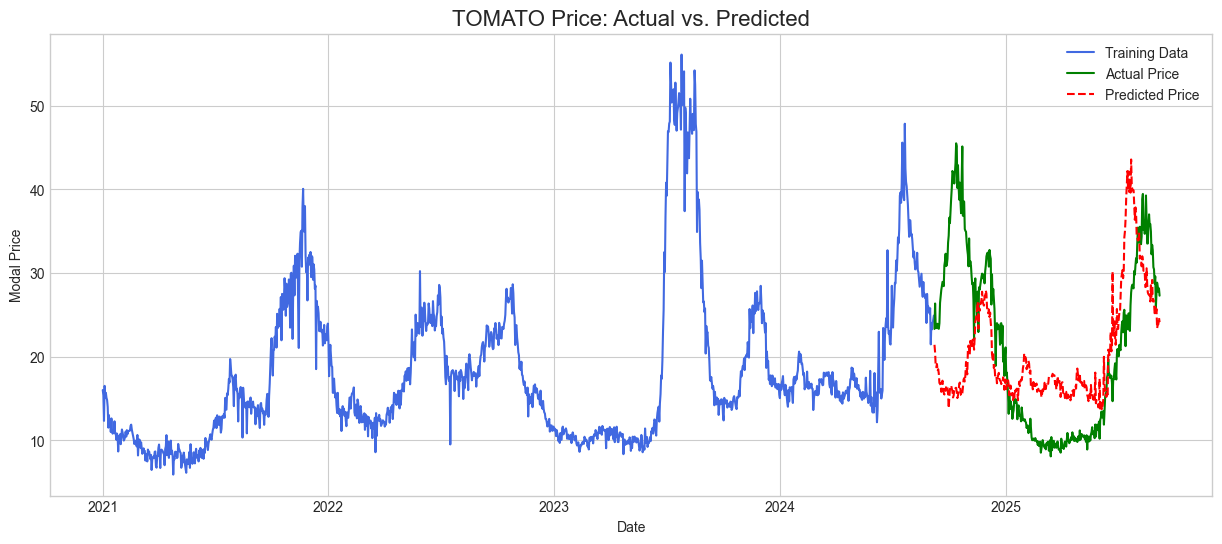

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

def avg_predicted_price(commodity):
    df_commodity = df_final[df_final['commodity'] == commodity].copy()
    df_commodity = df_commodity.groupby(df_commodity.index).mean(numeric_only=True) 
    
    df_commodity = df_commodity['modal_price'].resample('D').ffill().to_frame()
    
    
    df_commodity = create_time_features(df_commodity)
    
    split_date = df_commodity.index.max() - pd.Timedelta(days=365)
    train_df = df_commodity.loc[df_commodity.index <= split_date]
    test_df = df_commodity.loc[df_commodity.index > split_date]
    
    FEATURES = ['dayofweek', 'dayofyear', 'month', 'year', 'quarter', 'weekofyear']
    TARGET = 'modal_price'
    
    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]
    
    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]
    
    
    model = xgb.XGBRegressor(
        n_estimators=1000,    
        learning_rate=0.6,   
        objective='reg:squarederror',
        eval_metric='mae',
        early_stopping_rounds=20 
    )
    
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100) 
    
    
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"\nModel's Mean Absolute Error on the Test Set: {mae:.2f}")
    
    r2 = r2_score(y_test, predictions)
    print(f"R-squared (R²): {r2:.2f}")
    
    
    test_df['prediction'] = predictions
    
    plt.figure(figsize=(15, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    plt.plot(train_df.index, train_df['modal_price'], label='Training Data', color='royalblue')
    plt.plot(test_df.index, test_df['modal_price'], label='Actual Price', color='green')
    plt.plot(test_df.index, test_df['prediction'], label='Predicted Price', color='red', linestyle='--')
    
    plt.title(f'{commodity} Price: Actual vs. Predicted', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Modal Price')
    plt.legend()
    plt.show()

avg_predicted_price('TOMATO')

[0]	validation_0-mae:6.42090	validation_1-mae:9.13006
[25]	validation_0-mae:3.99605	validation_1-mae:8.90877

Model for 'TOMATO'
Mean Absolute Error on Test Set: 8.36
R-squared (R²): 0.29


C:\Users\WELCOME\AppData\Local\Temp\ipykernel_7036\1661914245.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'prediction'] = predictions


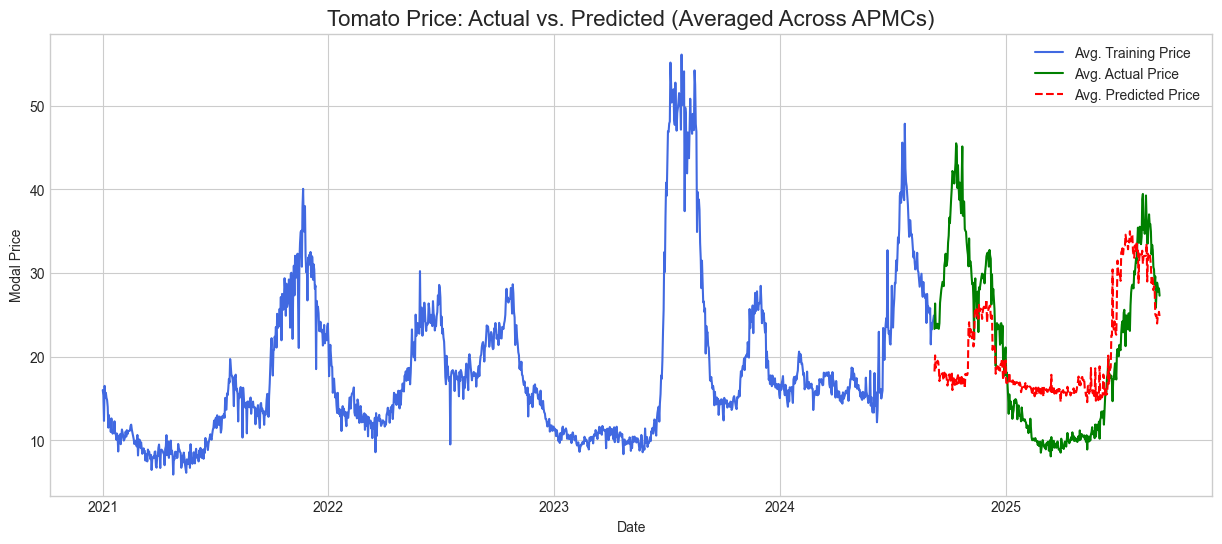

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score


def ampc_avg_predicted_price(df_master, commodity):
    
    df = df_master[df_master['commodity'] == commodity].copy()


    df = df.groupby([df.index, 'state', 'apmc']).modal_price.mean().reset_index()  # average is all three same 
    df = df.set_index('created_at')

    df['state_code'] = df['state'].astype('category').cat.codes
    df['apmc_code'] = df['apmc'].astype('category').cat.codes

    def create_time_features(df_to_feature):
        df_to_feature['dayofweek'] = df_to_feature.index.dayofweek
        df_to_feature['dayofyear'] = df_to_feature.index.dayofyear
        df_to_feature['month'] = df_to_feature.index.month
        df_to_feature['year'] = df_to_feature.index.year
        df_to_feature['quarter'] = df_to_feature.index.quarter
        df_to_feature['weekofyear'] = df_to_feature.index.isocalendar().week.astype(int)
        return df_to_feature
    
    df = create_time_features(df)
    
    split_date = df.index.max() - pd.Timedelta(days=365)
    
    train_df = df.loc[df.index <= split_date]
    test_df = df.loc[df.index > split_date]
    
    FEATURES = [
        'dayofweek', 'dayofyear', 'month', 'year', 'quarter', 'weekofyear',
        'state_code', 'apmc_code'
    ]
    TARGET = 'modal_price'
    
    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]
    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]
    
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.6,
        objective='reg:squarederror',
        eval_metric='mae',
        early_stopping_rounds=20
    )
    
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
    
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"\nModel for '{commodity}'")
    print(f"Mean Absolute Error on Test Set: {mae:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    
    test_df.loc[:, 'prediction'] = predictions
    
    plot_test_df = test_df.groupby(test_df.index).mean(numeric_only=True)
    plot_train_df = train_df.groupby(train_df.index).mean(numeric_only=True)
    
    plt.figure(figsize=(15, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    plt.plot(plot_train_df.index, plot_train_df['modal_price'], label='Avg. Training Price', color='royalblue')
    plt.plot(plot_test_df.index, plot_test_df['modal_price'], label='Avg. Actual Price', color='green')
    plt.plot(plot_test_df.index, plot_test_df['prediction'], label='Avg. Predicted Price', color='red', linestyle='--')
    
    plt.title(f'{commodity.title()} Price: Actual vs. Predicted (Averaged Across APMCs)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Modal Price')
    plt.legend()
    plt.show()

ampc_avg_predicted_price(df_final, "TOMATO")

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

def _create_time_features(df):
    """
    Helper function to create time series features from a datetime index.
    """
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

def analyze_and_predict_best_sell_date(df_master, commodity_to_analyze, state_to_analyze, start_date_str):
    """
    Analyzes historical data, forecasts prices for the next 30 days, identifies the best
    sell date, and provides a visual analysis including comparison with actual data if available.
    """
    print(f"📈 Starting analysis for '{commodity_to_analyze.title()}' in '{state_to_analyze.title()}'...")

    # ===================================================================
    # 1. Data Filtering & Validation
    # ===================================================================
    df_filtered = df_master[(df_master['commodity'] == commodity_to_analyze) & (df_master['state'] == state_to_analyze)].copy()

    if df_filtered.shape[0] < 100 or df_filtered.index.nunique() < 30:
        print(f"📉 Insufficient Data: Not enough historical data for '{commodity_to_analyze.title()}' in '{state_to_analyze.title()}' to make a reliable forecast.")
        return None

    df_train = df_filtered.groupby([df_filtered.index, 'apmc']).modal_price.mean().reset_index()
    df_train = df_train.set_index('created_at')

    # ===================================================================
    # 2. Feature Engineering & Model Training
    # ===================================================================
    df_train = _create_time_features(df_train)
    le_apmc = LabelEncoder()
    df_train['apmc_code'] = le_apmc.fit_transform(df_train['apmc'])
    
    FEATURES = ['dayofweek', 'dayofyear', 'month', 'year', 'quarter', 'weekofyear', 'apmc_code']
    TARGET = 'modal_price'

    X_train, y_train = df_train[FEATURES], df_train[TARGET]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    print("✅ Model trained successfully on historical data.")
    
    # ===================================================================
    # 3. Prepare Future Data for Prediction
    # ===================================================================
    start_date = pd.to_datetime(start_date_str)
    future_dates = pd.date_range(start=start_date, periods=30, freq='D')
    apmcs_in_state = df_train['apmc'].unique()

    future_grid = pd.DataFrame(list(product(future_dates, apmcs_in_state)), columns=['date', 'apmc'])
    future_grid = future_grid.set_index('date')

    future_grid = _create_time_features(future_grid)
    future_grid['apmc_code'] = le_apmc.transform(future_grid['apmc'])

    # ===================================================================
    # 4. Make Predictions & Find the Best Sell Date
    # ===================================================================
    future_predictions = model.predict(future_grid[FEATURES])
    future_grid['predicted_price'] = future_predictions

    daily_best = future_grid.loc[future_grid.groupby(future_grid.index)['predicted_price'].idxmax()]
    best_sell_day = daily_best.loc[daily_best['predicted_price'].idxmax()]
    
    print("🔍 Analysis complete.")

    # ===================================================================
    # 5. Generate Analysis & Visualization
    # ===================================================================
    avg_daily_price = future_grid.groupby('date')['predicted_price'].mean()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    ax.plot(avg_daily_price.index, avg_daily_price.values, label='Avg. Predicted Price Trend', color='dodgerblue', zorder=2)
    ax.fill_between(avg_daily_price.index, avg_daily_price.values, color='dodgerblue', alpha=0.1)

    best_date = best_sell_day.index[0]
    best_price = best_sell_day['predicted_price'].iloc[0]
    best_apmc = best_sell_day['apmc'].iloc[0]

    ax.axvline(x=best_date, color='red', linestyle='--', linewidth=2, label=f"Best Sell Day ({best_date.strftime('%b %d')})", zorder=3)
    ax.scatter(best_date, best_price, color='red', s=100, zorder=4, ec='black')
    
    ax.annotate(f"Highest Price: ₹{best_price:,.2f}\nin {best_apmc}",
                xy=(best_date, best_price),
                xytext=(15, -30),
                textcoords='offset points',
                ha='left', va='top', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1", color='black'))

    # ✨ NEW: Plot Actual Data if Available for Comparison ✨
    # =======================================================
    actual_data_in_forecast = df_train.loc[df_train.index.isin(future_dates)]
    
    if not actual_data_in_forecast.empty:
        avg_actual_price = actual_data_in_forecast.groupby(actual_data_in_forecast.index)['modal_price'].mean()
        ax.plot(avg_actual_price.index, avg_actual_price.values, 
                label='Avg. Actual Price', color='green', marker='o', linestyle='-', zorder=5)
        print("ℹ️ Actual data found within the forecast period and has been plotted for comparison.")
    # =======================================================

    ax.set_title(f"30-Day Price Forecast for {commodity_to_analyze.title()} in {state_to_analyze.title()}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Predicted Modal Price (₹)", fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50)
    print("📊 FORECAST SUMMARY 📊")
    print("="*50)
    print(f"Commodity: {commodity_to_analyze.title()}")
    print(f"State: {state_to_analyze.title()}")
    print("\nBased on the forecast for the next 30 days:")
    print(f"  - The **best day to sell** is on: {best_date.strftime('%A, %B %d, %Y')}")
    print(f"  - The **highest predicted price** is: ₹{best_price:,.2f}")
    print(f"  - This price is expected at the **{best_apmc}** market.")
    print("="*50)
    
    return {
        'best_sell_date': best_date.strftime('%Y-%m-%d'),
        'highest_price': best_price,
        'location': best_apmc
    }

📈 Starting analysis for 'Tomato' in 'Uttar Pradesh'...
✅ Model trained successfully on historical data.
🔍 Analysis complete.
ℹ️ Actual data found within the forecast period and has been plotted for comparison.


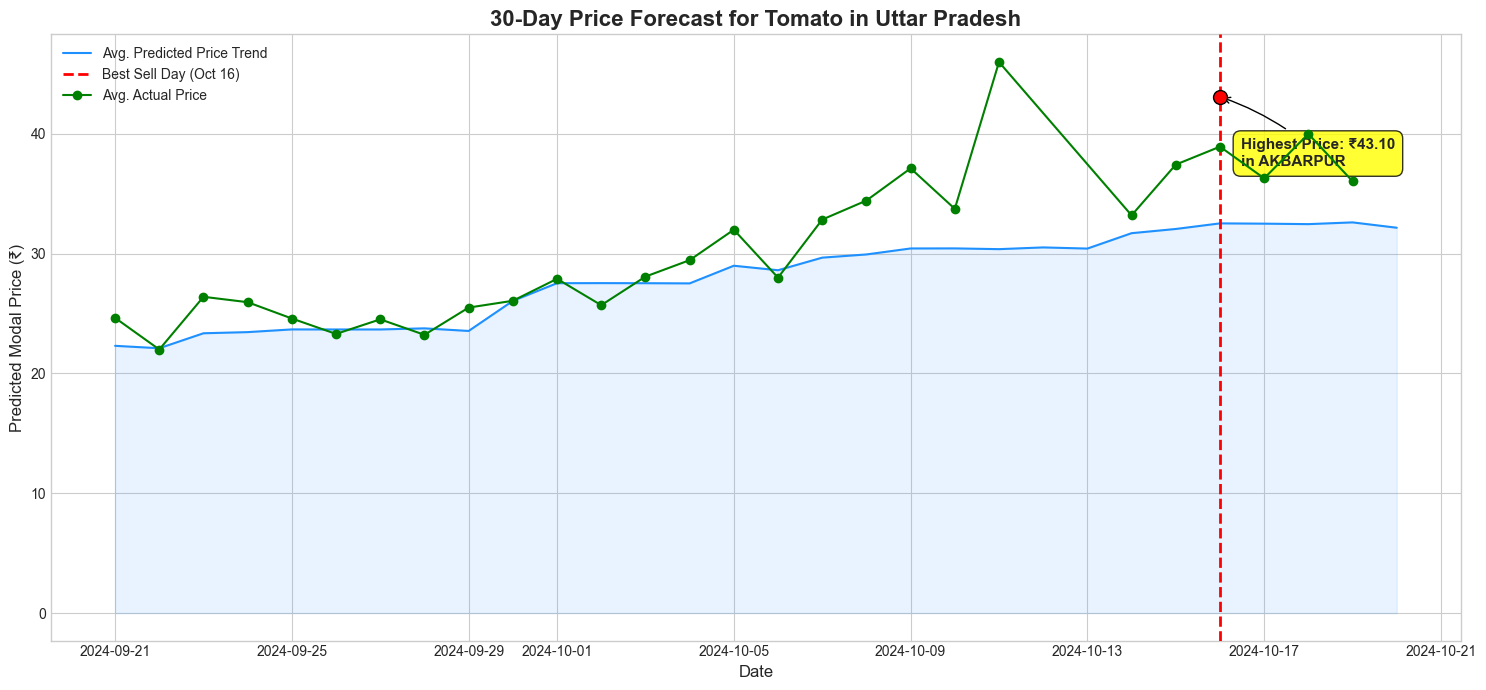


📊 FORECAST SUMMARY 📊
Commodity: Tomato
State: Uttar Pradesh

Based on the forecast for the next 30 days:
  - The **best day to sell** is on: Wednesday, October 16, 2024
  - The **highest predicted price** is: ₹43.10
  - This price is expected at the **AKBARPUR** market.


In [8]:

analysis_result = analyze_and_predict_best_sell_date(
    df_master=df_final,
    commodity_to_analyze='TOMATO',
    state_to_analyze='UTTAR PRADESH',
    start_date_str='2024-09-21' 
)

# === EXAMPLE 2: Insufficient Data ===
# This will trigger the data validation check if 'rocket' is a rare commodity.
# analysis_result_fail = analyze_and_predict_best_sell_date(
#     df_master=df_final,
#     commodity_to_analyze='rocket',
#     state_to_analyze='GOA',
#     start_date_str='2025-09-21'
# )

## REAL

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

class CommodityPricePredictor:
    """
    An upgraded class to train, evaluate, and forecast prices for multiple 
    commodities, with models that are aware of state and APMC locations.
    """
    def __init__(self, df):
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError("DataFrame index must be a DatetimeIndex.")
        self.df_full = df.copy()
        # Models dictionary will now store the model AND its encoders
        self.models = {} 
        print("✅ Predictor initialized.")

    def _create_time_features(self, df):
        """Creates time-series features from a datetime index."""
        df = df.copy()
        df['dayofweek'] = df.index.dayofweek
        df['dayofyear'] = df.index.dayofyear
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['weekofyear'] = df.index.isocalendar().week.astype(int)
        return df

    def train(self, commodity):
        """
        Trains an APMC-aware model for a specific commodity.
        """
        print(f"--- Training APMC-aware model for: {commodity.title()} ---")

        # 1. Filter and clean data
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        
        # Lowered the data requirement for testing purposes.
        if df_commodity.shape[0] < 50:
            print(f"⚠️ Warning: Insufficient data for {commodity} (less than 50 rows). Skipping training.")
            return

        df_train = df_commodity.groupby([df_commodity.index, 'state', 'apmc']).modal_price.mean().reset_index()
        df_train = df_train.set_index('created_at')

        # 2. Feature Engineering
        df_train = self._create_time_features(df_train)
        
        le_state = LabelEncoder()
        le_apmc = LabelEncoder()
        df_train['state_code'] = le_state.fit_transform(df_train['state'])
        df_train['apmc_code'] = le_apmc.fit_transform(df_train['apmc'])
        
        FEATURES = ['dayofweek', 'dayofyear', 'month', 'year', 'quarter', 'weekofyear', 'state_code', 'apmc_code']
        TARGET = 'modal_price'

        X_train, y_train = df_train[FEATURES], df_train[TARGET]

        # 3. Train the XGBoost model
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, random_state=42)
        model.fit(X_train, y_train, verbose=False)

        # 4. Store the model AND the encoders for future prediction
        self.models[commodity] = {
            'model': model,
            'state_encoder': le_state,
            'apmc_encoder': le_apmc,
            'features': FEATURES
        }
        print(f"✅ APMC-aware model for {commodity.title()} trained and stored.")

    def analyze_sell_date_by_state(self, commodity, state, start_date_str):
        """
        Analyzes and predicts the best date to sell a commodity in a given state
        over the next 30 days, including a visual analysis with real data comparison.
        """
        print(f"\n📈 Starting 30-day forecast for '{commodity.title()}' in '{state.title()}'...")
        
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found. Please train it first using .train('{commodity}')")
            return None

        artifacts = self.models[commodity]
        model, le_state, le_apmc, features = artifacts['model'], artifacts['state_encoder'], artifacts['apmc_encoder'], artifacts['features']

        start_date = pd.to_datetime(start_date_str)
        future_dates = pd.date_range(start=start_date, periods=30, freq='D')
        
        all_apmcs = le_apmc.classes_
        state_apmcs = self.df_full[(self.df_full['state'] == state) & (self.df_full['apmc'].isin(all_apmcs))]['apmc'].unique()

        if len(state_apmcs) == 0:
            print(f"⚠️ Warning: No known APMCs found for the state '{state}'.")
            return None
        
        future_grid = pd.DataFrame(list(product(future_dates, state_apmcs)), columns=['date', 'apmc'])
        future_grid['state'] = state
        future_grid = future_grid.set_index('date')

        future_grid = self._create_time_features(future_grid)
        future_grid['state_code'] = le_state.transform(future_grid['state'])
        future_grid['apmc_code'] = le_apmc.transform(future_grid['apmc'])

        future_predictions = model.predict(future_grid[features])
        future_grid['predicted_price'] = future_predictions

        daily_best = future_grid.loc[future_grid.groupby(future_grid.index)['predicted_price'].idxmax()]
        best_sell_day = daily_best.loc[daily_best['predicted_price'].idxmax()]
        
        print("🔍 Analysis complete.")

        avg_daily_price = future_grid.groupby('date')['predicted_price'].mean()
        
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(15, 7))

        ax.plot(avg_daily_price.index, avg_daily_price.values, label='Avg. Predicted Price Trend', color='dodgerblue')
        best_date = best_sell_day.index[0]
        best_price = best_sell_day['predicted_price'].iloc[0]
        best_apmc = best_sell_day['apmc'].iloc[0]

        ax.axvline(x=best_date, color='red', linestyle='--', label=f"Best Sell Day ({best_date.strftime('%b %d')})")
        ax.scatter(best_date, best_price, color='red', s=100, zorder=5, ec='black')

        # ✨ NEW: Plot actual data if available for comparison ✨
        # =======================================================
        actual_data_in_forecast = self.df_full[
            (self.df_full['commodity'] == commodity) &
            (self.df_full['state'] == state) &
            (self.df_full.index.isin(future_dates))
        ]
        
        if not actual_data_in_forecast.empty:
            avg_actual_price = actual_data_in_forecast.groupby(actual_data_in_forecast.index)['modal_price'].mean()
            ax.plot(avg_actual_price.index, avg_actual_price.values, 
                    label='Avg. Actual Price', color='green', marker='o', linestyle='-')
            print("ℹ️ Actual data found within the forecast period and has been plotted for comparison.")
        # =======================================================
        
        ax.set_title(f"30-Day Price Forecast for {commodity.title()} in {state.title()}", fontsize=16, fontweight='bold')
        ax.set_xlabel("Date"), ax.set_ylabel("Predicted Modal Price (₹)")
        ax.legend()
        plt.tight_layout(), plt.show()

        print("\n" + "="*50 + "\n📊 FORECAST SUMMARY 📊\n" + "="*50)
        print(f"Commodity: {commodity.title()}\nState: {state.title()}\n")
        print("Based on the forecast for the next 30 days:")
        print(f"  - The **best day to sell** is on: {best_date.strftime('%A, %B %d, %Y')}")
        print(f"  - The **highest predicted price** is: ₹{best_price:,.2f}")
        print(f"  - This price is expected at the **{best_apmc}** market.")
        print("="*50)
        
        return {'best_sell_date': best_date, 'highest_price': best_price, 'location': best_apmc}

✅ Predictor initialized.
--- Training APMC-aware model for: Tomato ---
✅ APMC-aware model for Tomato trained and stored.
--- Training APMC-aware model for: Cabbage ---
✅ APMC-aware model for Cabbage trained and stored.

📈 Starting 30-day forecast for 'Tomato' in 'Uttar Pradesh'...
🔍 Analysis complete.
ℹ️ Actual data found within the forecast period and has been plotted for comparison.


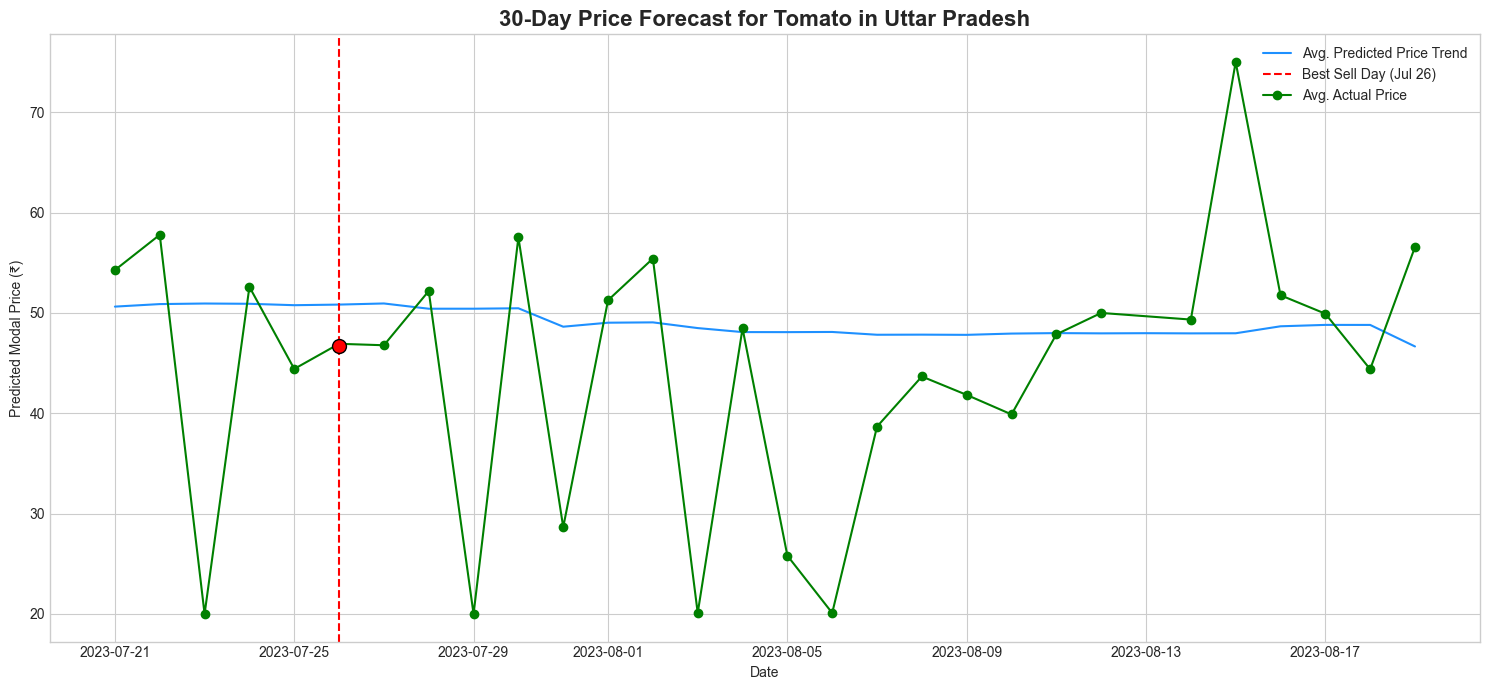


📊 FORECAST SUMMARY 📊
Commodity: Tomato
State: Uttar Pradesh

Based on the forecast for the next 30 days:
  - The **best day to sell** is on: Wednesday, July 26, 2023
  - The **highest predicted price** is: ₹46.71
  - This price is expected at the **HARDOI** market.


{'best_sell_date': Timestamp('2023-07-26 00:00:00'),
 'highest_price': np.float32(46.71208),
 'location': 'HARDOI'}

In [10]:
# Assume 'df_final' is your loaded DataFrame with a 'created_at' DatetimeIndex
predictor = CommodityPricePredictor(df_final)

# 2. Train the models (this should now work if you have > 50 data points)
predictor.train('TOMATO')
predictor.train('CABBAGE')

# 3. Run the analysis
predictor.analyze_sell_date_by_state(
    commodity='TOMATO', 
    state='UTTAR PRADESH', 
    start_date_str='2023-07-21'
)

### DEEP

In [11]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt
# import warnings
# from itertools import product

# warnings.filterwarnings('ignore')

# class CommodityPricePredictor:
#     """
#     A class to train, evaluate, and forecast commodity prices using LSTM models.
#     """
#     def __init__(self, df):
#         if not isinstance(df.index, pd.DatetimeIndex):
#             df['created_at'] = pd.to_datetime(df['created_at'])
#             df = df.set_index('created_at').sort_index()
#         self.df_full = df.copy()
#         self.models = {}
#         print("✅ Predictor initialized.")

#     def _create_time_features(self, df):
#         """Creates time-series features from a datetime index."""
#         df = df.copy()
#         df['dayofweek'] = df.index.dayofweek
#         df['dayofyear'] = df.index.dayofyear
#         df['month'] = df.index.month
#         df['year'] = df.index.year
#         df['quarter'] = df.index.quarter
#         df['weekofyear'] = df.index.isocalendar().week.astype(int)
#         return df

#     def _prepare_data_for_lstm(self, data, look_back=30):
#         """
#         Prepares data for the LSTM model by creating sequences.
#         """
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

#         X, y = [], []
#         for i in range(len(scaled_data) - look_back):
#             X.append(scaled_data[i:(i + look_back), 0])
#             y.append(scaled_data[i + look_back, 0])
#         return np.array(X), np.array(y), scaler

#     def train(self, commodity):
#         """
#         Trains an LSTM model for a specific commodity.
#         """
#         print(f"--- Training model for: {commodity.title()} ---")
#         df_commodity = self.df_full[self.df_full['commodity'] == commodity]
#         if df_commodity.shape[0] < 60:
#             print(f"⚠️ Warning: Insufficient data for {commodity}. Skipping training.")
#             return

#         data = df_commodity.groupby(df_commodity.index).modal_price.mean()
#         X, y, scaler = self._prepare_data_for_lstm(data, 30)
#         X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#         model = Sequential()
#         model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
#         model.add(LSTM(units=50))
#         model.add(Dense(units=1))
#         model.compile(optimizer='adam', loss='mean_squared_error')
#         model.fit(X, y, epochs=20, batch_size=32, verbose=0)

#         self.models[commodity] = {'model': model, 'scaler': scaler, 'look_back': 30}
#         print(f"✅ Model for {commodity.title()} trained and stored.")

#     def analyze_sell_date_by_state(self, commodity, state, start_date_str):
#         """
#         Analyzes and predicts the best date to sell a commodity in a given state.
#         """
#         print(f"\n📈 Starting 30-day forecast for '{commodity.title()}' in '{state.title()}'...")

#         if commodity not in self.models:
#             print(f"❌ Error: Model for {commodity} not found. Please train it first.")
#             return None

#         model_artifacts = self.models[commodity]
#         model = model_artifacts['model']
#         scaler = model_artifacts['scaler']
#         look_back = model_artifacts['look_back']

#         df_state = self.df_full[(self.df_full['commodity'] == commodity) & (self.df_full['state'] == state)]
#         if df_state.shape[0] < look_back:
#             print(f"📉 Insufficient Data for '{commodity.title()}' in '{state.title()}'.")
#             return None

#         data = df_state.groupby(df_state.index).modal_price.mean()
#         last_known_data = data.tail(look_back).values.reshape(-1, 1)
#         scaled_input = scaler.transform(last_known_data)

#         predictions = []
#         current_input = scaled_input
#         for _ in range(30):
#             prediction = model.predict(current_input.reshape(1, look_back, 1))
#             predictions.append(prediction[0][0])
#             current_input = np.append(current_input[1:], prediction, axis=0)

#         predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        
#         start_date = pd.to_datetime(start_date_str)
#         future_dates = pd.date_range(start=start_date, periods=30, freq='D')
        
#         forecast_df = pd.DataFrame(predicted_prices, index=future_dates, columns=['predicted_price'])
        
#         best_sell_day = forecast_df['predicted_price'].idxmax()
#         highest_price = forecast_df['predicted_price'].max()
        
#         print("🔍 Analysis complete.")

#         plt.style.use('seaborn-v0_8-whitegrid')
#         fig, ax = plt.subplots(figsize=(15, 7))

#         ax.plot(data.index, data.values, label='Historical Prices', color='gray')
#         ax.plot(forecast_df.index, forecast_df['predicted_price'], label='Forecasted Prices', color='dodgerblue')
#         ax.axvline(x=best_sell_day, color='red', linestyle='--', label=f"Best Sell Day ({best_sell_day.strftime('%b %d')})")
        
#         ax.set_title(f"30-Day Price Forecast for {commodity.title()} in {state.title()}", fontsize=16, fontweight='bold')
#         ax.set_xlabel("Date", fontsize=12)
#         ax.set_ylabel("Modal Price (₹)", fontsize=12)
#         ax.legend()
#         plt.tight_layout()
#         plt.show()

#         print("\n" + "="*50)
#         print("📊 FORECAST SUMMARY 📊")
#         print("="*50)
#         print(f"Commodity: {commodity.title()}")
#         print(f"State: {state.title()}")
#         print(f"\nBased on the forecast for the next 30 days:")
#         print(f"  - The **best day to sell** is on: {best_sell_day.strftime('%A, %B %d, %Y')}")
#         print(f"  - The **highest predicted price** is: ₹{highest_price:,.2f}")
#         print("="*50)
        
#         return {'best_sell_date': best_sell_day.strftime('%Y-%m-%d'), 'highest_price': highest_price}


✅ Predictor initialized.
--- Training model for: Potato ---
✅ Model for Potato trained and stored.

📈 Starting 30-day forecast for 'Potato' in 'Uttar Pradesh'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/s

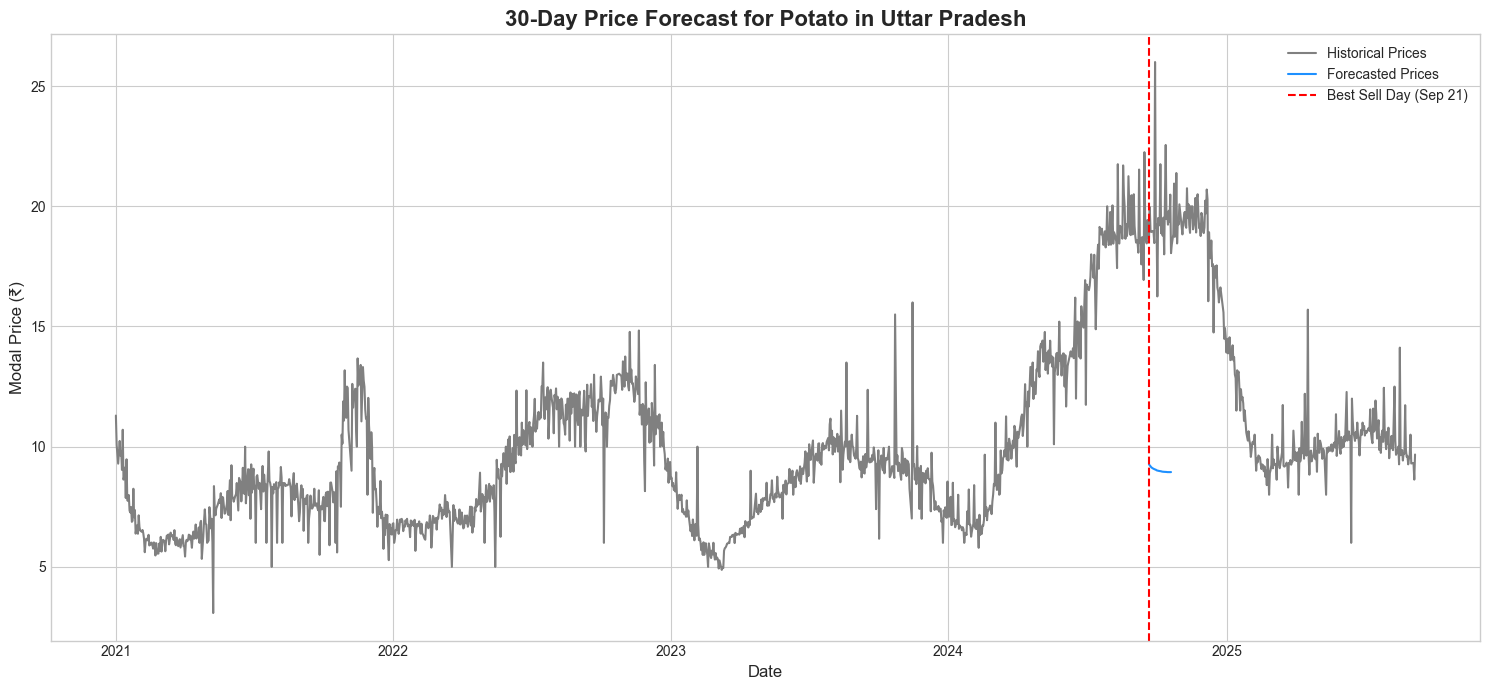


📊 FORECAST SUMMARY 📊
Commodity: Potato
State: Uttar Pradesh

Based on the forecast for the next 30 days:
  - The **best day to sell** is on: Saturday, September 21, 2024
  - The **highest predicted price** is: ₹9.27


{'best_sell_date': '2024-09-21', 'highest_price': np.float32(9.26566)}

In [12]:
# # Assume 'df_final' is your loaded DataFrame with a DatetimeIndex

# # 1. Initialize the predictor
# dl_predictor = CommodityPricePredictor(df_final)

# # 2. Train a model for a commodity with sufficient data
# #    (This will take a few minutes depending on your data size and hardware)
# dl_predictor.train('POTATO') 

# # 3. Run the analysis
# dl_predictor.analyze_sell_date_by_state(
#     commodity='POTATO', 
#     state='UTTAR PRADESH', 
#     start_date_str='2024-09-21'
# )

✅ Predictor initialized.
--- Training model for: Tomato ---
✅ Model for Tomato trained and stored.

📈 Starting 30-day forecast for 'Tomato' in 'Uttar Pradesh'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

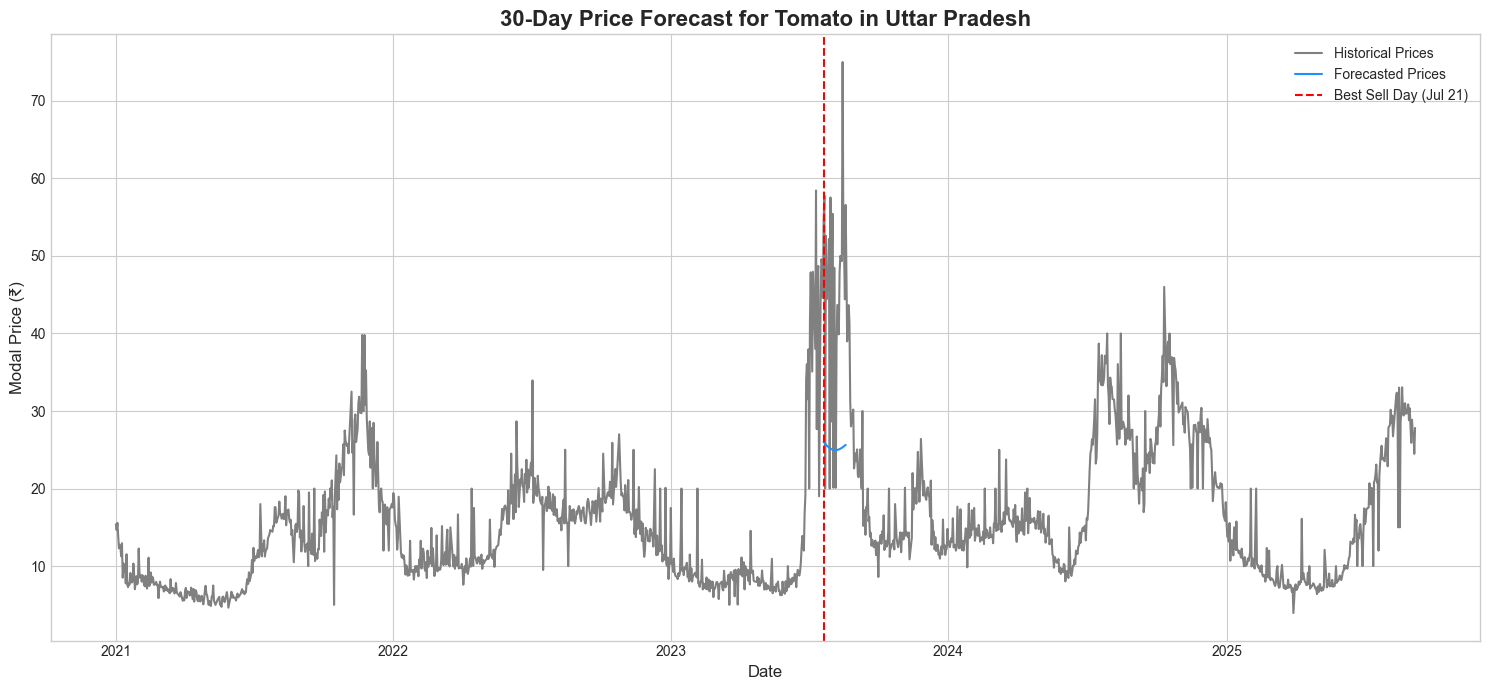


📊 FORECAST SUMMARY 📊
Commodity: Tomato
State: Uttar Pradesh

Based on the forecast for the next 30 days:
  - The **best day to sell** is on: Friday, July 21, 2023
  - The **highest predicted price** is: ₹26.06


{'best_sell_date': '2023-07-21', 'highest_price': np.float32(26.055027)}

In [13]:
# # Create a predictor instance
# predictor = CommodityPricePredictor(df_final)

    
# predictor.train('TOMATO')

# predictor.analyze_sell_date_by_state(
#         commodity='TOMATO', 
#         state='UTTAR PRADESH', 
#         start_date_str='2023-07-21'
#     )


✅ Predictor initialized.
--- Training model for: Rice ---
✅ Model for Rice trained and stored.

📈 Starting 30-day forecast for 'Rice' in 'Uttar Pradesh'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/ste

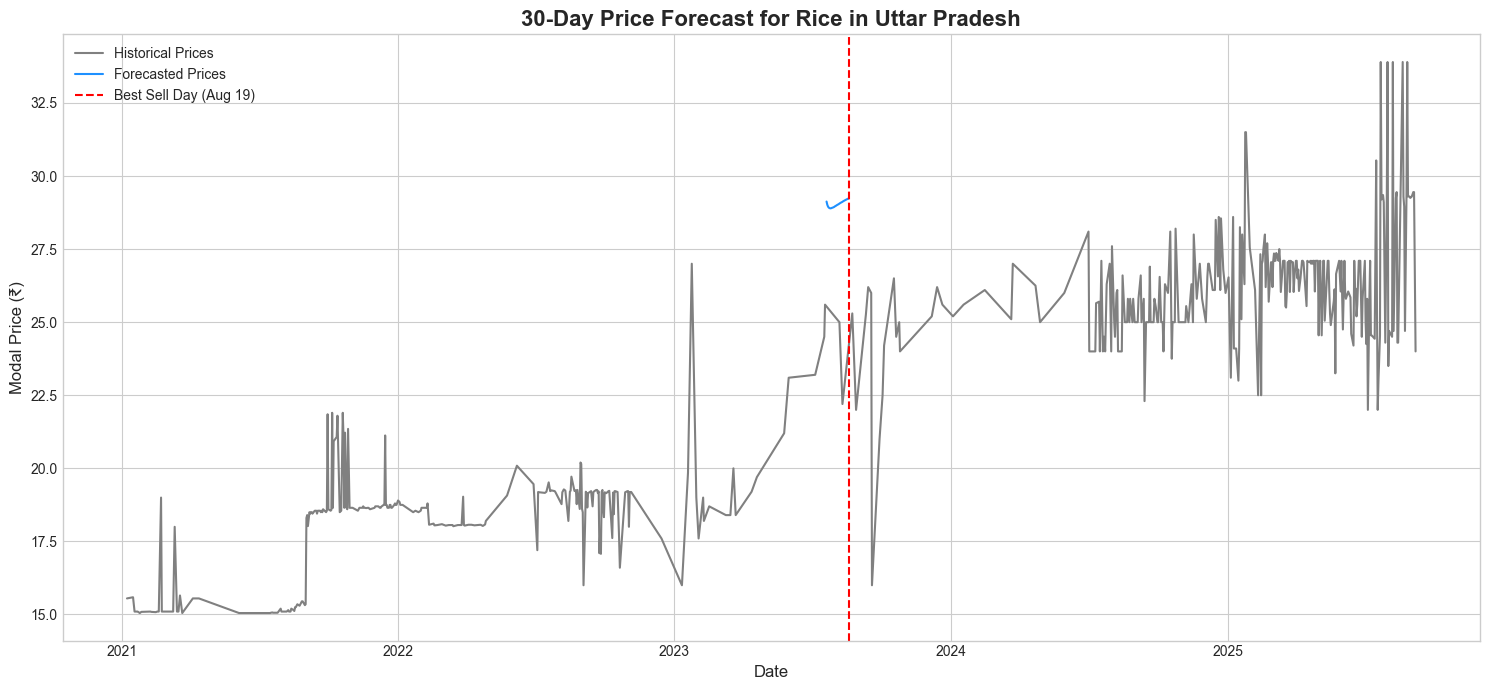


📊 FORECAST SUMMARY 📊
Commodity: Rice
State: Uttar Pradesh

Based on the forecast for the next 30 days:
  - The **best day to sell** is on: Saturday, August 19, 2023
  - The **highest predicted price** is: ₹29.23


{'best_sell_date': '2023-08-19', 'highest_price': np.float32(29.232044)}

In [14]:
# # Create a predictor instance
# predictor = CommodityPricePredictor(df_final)

    
# predictor.train('RICE')

# predictor.analyze_sell_date_by_state(
#         commodity='RICE', 
#         state='UTTAR PRADESH', 
#         start_date_str='2023-07-21'
#     )


### Best

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

class CommodityPricePredictor:
    """
    A class to train, evaluate, and predict prices for multiple commodities
    using separate XGBoost models.
    """
    def __init__(self, df):
        """
        Initializes the predictor with the full dataframe.
        """
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError("DataFrame index must be a DatetimeIndex.")
        self.df_full = df.copy()
        self.models = {} # To store a trained model for each commodity
        print("✅ Predictor initialized.")

    def _create_features(self, df):
        """
        Creates time-series features for the given dataframe.
        """
        df = df.copy()
        # Time-based features
        df['dayofweek'] = df.index.dayofweek
        df['dayofyear'] = df.index.dayofyear
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['weekofyear'] = df.index.isocalendar().week.astype(int)

        # Lag features (price from previous periods)
        df['price_lag_7'] = df['modal_price'].shift(7)
        df['price_lag_14'] = df['modal_price'].shift(14)
        df['price_lag_30'] = df['modal_price'].shift(30)

        # Rolling window features (trend over the last month)
        df['rolling_mean_30'] = df['modal_price'].shift(1).rolling(window=30).mean()
        df['rolling_std_30'] = df['modal_price'].shift(1).rolling(window=30).std()

        return df.dropna()

    def train(self, commodity):
        """
        Trains a new XGBoost model for a specific commodity.
        """
        print(f"--- Training model for: {commodity} ---")

        # 1. Filter data for the specific commodity and APMC
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        if df_commodity.empty:
            print(f"⚠️ Warning: No data found for {commodity}. Skipping training.")
            return

        # Aggregate data to have one price per day for the commodity
        df_daily = df_commodity.groupby(df_commodity.index).agg({
            'modal_price': 'mean' # Use the average price for that day
        })

        # 2. Create features
        df_featured = self._create_features(df_daily)

        # 3. Split data as requested (Train up to 2023 end, test on 2024+)
        train_df = df_featured.loc[df_featured.index < '2024-01-01']
        test_df = df_featured.loc[df_featured.index >= '2024-01-01']

        if test_df.empty or train_df.empty:
            print(f"⚠️ Warning: Not enough data to perform train/test split for {commodity}.")
            return

        print(f"Training data from {train_df.index.min().date()} to {train_df.index.max().date()}")
        print(f"Testing data from {test_df.index.min().date()} to {test_df.index.max().date()}")

        FEATURES = [col for col in df_featured.columns if col != 'modal_price']
        TARGET = 'modal_price'

        X_train, y_train = train_df[FEATURES], train_df[TARGET]
        X_test, y_test = test_df[FEATURES], test_df[TARGET]

        # 4. Train the XGBoost model
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            eval_metric='mae',
            early_stopping_rounds=20
        )

        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)

        # 5. Store the trained model
        self.models[commodity] = model
        print(f"✅ Model for {commodity} trained and stored.")
        self.evaluate(commodity, test_df) # Evaluate right after training

    def evaluate(self, commodity, test_df):
        """
        Evaluates the model on the test set and plots the results.
        """
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found. Please train it first.")
            return

        model = self.models[commodity]
        FEATURES = [col for col in test_df.columns if col != 'modal_price']
        TARGET = 'modal_price'

        X_test, y_test = test_df[FEATURES], test_df[TARGET]
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        print(f"\n--- Evaluation Results for {commodity} ---")
        print(f"R-squared (R²): {r2:.3f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print("--------------------------------------")

        # Plotting
        plt.figure(figsize=(15, 6))
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.plot(y_test.index, y_test, label='Actual Price', color='green')
        plt.plot(y_test.index, predictions, label='Predicted Price', color='red', linestyle='--')
        plt.title(f'{commodity} Price: Actual vs. Predicted (2024 onwards)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Modal Price')
        plt.legend()
        plt.show()

    def predict_future(self, prediction_date_str, commodity):
        """
        Predicts the price for a future date.
        Note: This is a simplified prediction that uses historical data up to the present.
        """
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found. Please train it first.")
            return None

        prediction_date = pd.to_datetime(prediction_date_str)
        model = self.models[commodity]

        # To predict, we need to create features for the prediction date.
        # This requires looking at data *before* that date to create lags/rolling features.
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        df_daily = df_commodity.groupby(df_commodity.index).agg({'modal_price': 'mean'})

        # Append a dummy row for our future date to generate features
        future_df = pd.DataFrame(index=[prediction_date], columns=df_daily.columns)
        df_extended = pd.concat([df_daily, future_df])

        # Create features for the entire extended history
        df_featured = self._create_features(df_extended)

        # Get the very last row, which corresponds to our prediction date
        input_data = df_featured.iloc[-1:]
        
        if input_data.index != prediction_date:
            print(f"⚠️ Could not generate features for {prediction_date_str}. Date may be too far from data.")
            return None

        FEATURES = [col for col in input_data.columns if col != 'modal_price']
        final_input = input_data[FEATURES]

        prediction = model.predict(final_input)
        print(f"📈 Predicted price for {commodity} on {prediction_date.date()}: {prediction[0]:.2f}")
        return prediction[0]

✅ Predictor initialized.
--- Training model for: CABBAGE ---
Training data from 2021-01-31 to 2023-12-31
Testing data from 2024-01-01 to 2025-09-06
✅ Model for CABBAGE trained and stored.

--- Evaluation Results for CABBAGE ---
R-squared (R²): 0.731
Mean Absolute Error (MAE): 1.99
--------------------------------------


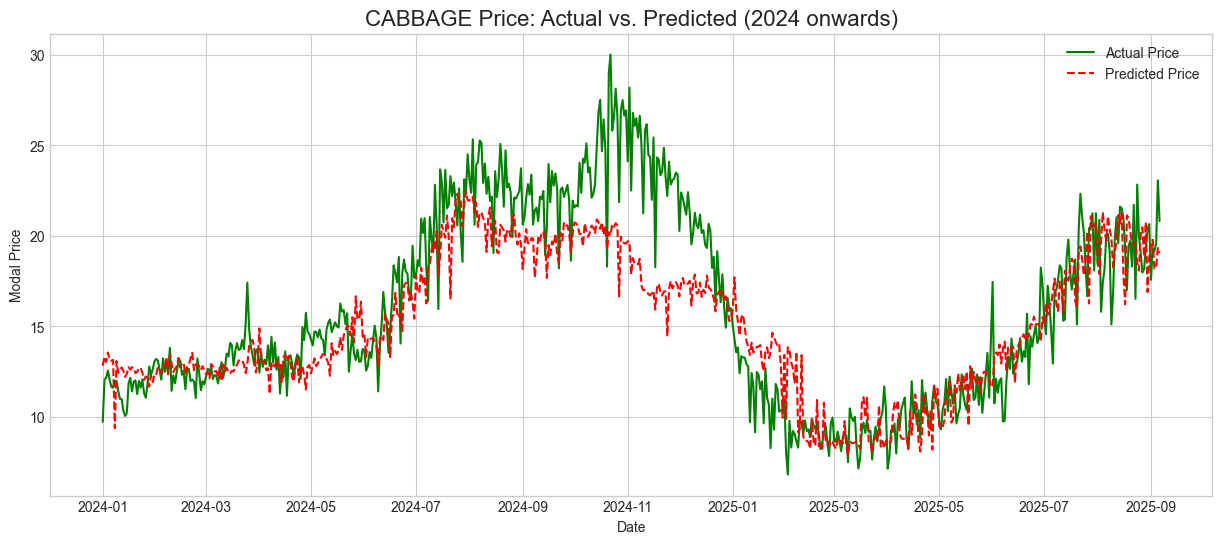

--- Training model for: TOMATO ---
Training data from 2021-01-31 to 2023-12-31
Testing data from 2024-01-01 to 2025-09-06
✅ Model for TOMATO trained and stored.

--- Evaluation Results for TOMATO ---
R-squared (R²): 0.781
Mean Absolute Error (MAE): 2.87
--------------------------------------


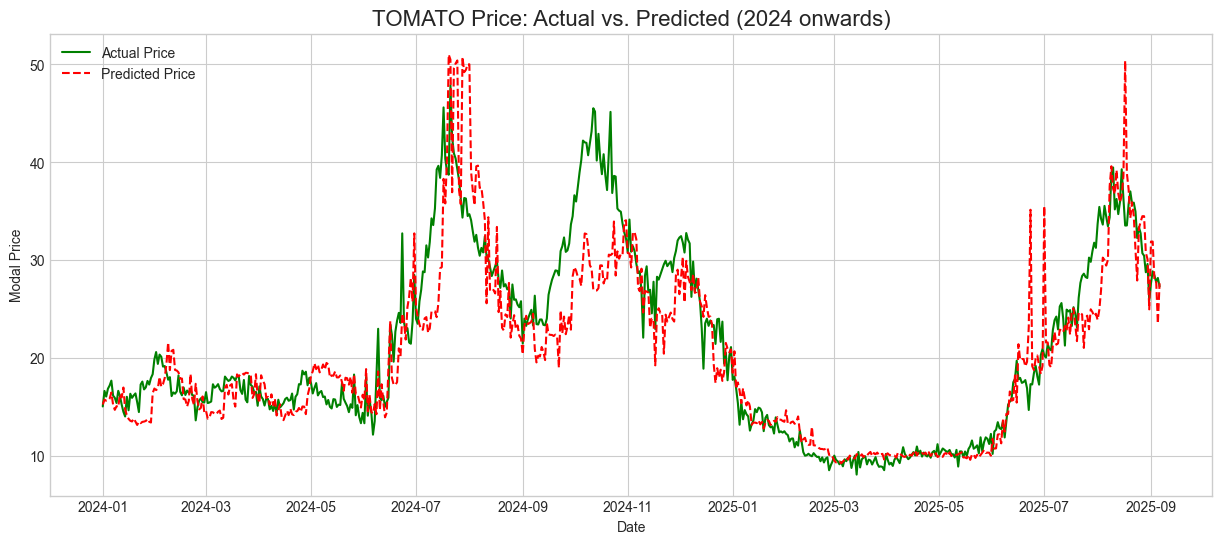

In [16]:
predictor = CommodityPricePredictor(df_final)

predictor.train(commodity='CABBAGE')
predictor.train(commodity='TOMATO')



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

class CommodityPricePredictor:
    """
    A class to train, evaluate, and predict prices for multiple commodities
    using separate XGBoost models.
    """
    def __init__(self, df):
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError("DataFrame index must be a DatetimeIndex.")
        self.df_full = df.copy()
        self.models = {} 
        print("✅ Predictor initialized.")

    def _create_features(self, df):
        df = df.copy()
        df['dayofweek'] = df.index.dayofweek
        df['dayofyear'] = df.index.dayofyear
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['weekofyear'] = df.index.isocalendar().week.astype(int)
        df['price_lag_7'] = df['modal_price'].shift(7)
        df['price_lag_14'] = df['modal_price'].shift(14)
        df['price_lag_30'] = df['modal_price'].shift(30)
        df['rolling_mean_30'] = df['modal_price'].shift(1).rolling(window=30).mean()
        df['rolling_std_30'] = df['modal_price'].shift(1).rolling(window=30).std()
        return df.dropna()

    def train(self, commodity):
        print(f"--- Training model for: {commodity} ---")
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        if df_commodity.empty:
            print(f"⚠️ Warning: No data found for {commodity}. Skipping training.")
            return

        df_daily = df_commodity.groupby(df_commodity.index).agg({'modal_price': 'mean'})
        df_featured = self._create_features(df_daily)
        train_df = df_featured.loc[df_featured.index < '2024-01-01']
        test_df = df_featured.loc[df_featured.index >= '2024-01-01']

        if test_df.empty or train_df.empty:
            print(f"⚠️ Warning: Not enough data for train/test split for {commodity}.")
            return

        print(f"Training data from {train_df.index.min().date()} to {train_df.index.max().date()}")
        print(f"Testing data from {test_df.index.min().date()} to {test_df.index.max().date()}")
        
        FEATURES = [col for col in df_featured.columns if col != 'modal_price']
        TARGET = 'modal_price'

        X_train, y_train = train_df[FEATURES], train_df[TARGET]
        X_test, y_test = test_df[FEATURES], test_df[TARGET]

        model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, eval_metric='mae', early_stopping_rounds=20)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        self.models[commodity] = model
        print(f"✅ Model for {commodity} trained and stored.")
        self.evaluate(commodity, test_df)

    def evaluate(self, commodity, test_df):
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found.")
            return
        
        model = self.models[commodity]
        FEATURES = [col for col in test_df.columns if col != 'modal_price']
        TARGET = 'modal_price'

        X_test, y_test = test_df[FEATURES], test_df[TARGET]
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        print(f"\n--- Evaluation Results for {commodity} ---")
        print(f"R-squared (R²): {r2:.3f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print("--------------------------------------")
        
        # New: Forecast and plot for the next 6 months
        forecast_df = self.forecast_six_months(commodity, test_df.index.max())

        plt.figure(figsize=(15, 6))
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.plot(y_test.index, y_test, label='Actual Price', color='green')
        plt.plot(y_test.index, predictions, label='Predicted Price (on test data)', color='red', linestyle='--')
        if forecast_df is not None:
            plt.plot(forecast_df.index, forecast_df['forecast'], label='6-Month Forecast', color='purple', linestyle=':')
        
        plt.title(f'{commodity} Price: Actual vs. Predicted & 6-Month Forecast', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Modal Price')
        plt.legend()
        plt.show()

    def forecast_six_months(self, commodity, last_known_date):
        """
        Forecasts the price for the next six months.
        """
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found.")
            return None

        model = self.models[commodity]
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        df_daily = df_commodity.groupby(df_commodity.index).agg({'modal_price': 'mean'})
        
        future_dates = pd.date_range(start=last_known_date, periods=180, freq='D')
        future_df = pd.DataFrame(index=future_dates, columns=['modal_price'])
        df_extended = pd.concat([df_daily, future_df])
        
        forecasts = []
        for date in future_dates:
            featured_row = self._create_features(df_extended.loc[:date]).iloc[-1:]
            FEATURES = [col for col in featured_row.columns if col != 'modal_price']
            prediction = model.predict(featured_row[FEATURES])[0]
            forecasts.append(prediction)
            df_extended.loc[date, 'modal_price'] = prediction
        
        forecast_df = pd.DataFrame({'forecast': forecasts}, index=future_dates)
        return forecast_df

    def predict_future(self, prediction_date_str, commodity):
        """
        Predicts the price for a specific future date.
        """
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found.")
            return None

        prediction_date = pd.to_datetime(prediction_date_str)
        model = self.models[commodity]
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        df_daily = df_commodity.groupby(df_commodity.index).agg({'modal_price': 'mean'})

        future_df = pd.DataFrame(index=[prediction_date], columns=df_daily.columns)
        df_extended = pd.concat([df_daily, future_df])

        df_featured = self._create_features(df_extended)
        input_data = df_featured.iloc[-1:]
        
        if input_data.index != prediction_date:
            print(f"⚠️ Could not generate features for {prediction_date_str}.")
            return None

        FEATURES = [col for col in input_data.columns if col != 'modal_price']
        final_input = input_data[FEATURES]

        prediction = model.predict(final_input)
        print(f"📈 Predicted price for {commodity} on {prediction_date.date()}: {prediction[0]:.2f}")
        return prediction[0]

✅ Predictor initialized.
--- Training model for: WHEAT ---
Training data from 2021-01-31 to 2023-12-31
Testing data from 2024-01-01 to 2025-09-06
✅ Model for WHEAT trained and stored.

--- Evaluation Results for WHEAT ---
R-squared (R²): 0.065
Mean Absolute Error (MAE): 1.10
--------------------------------------


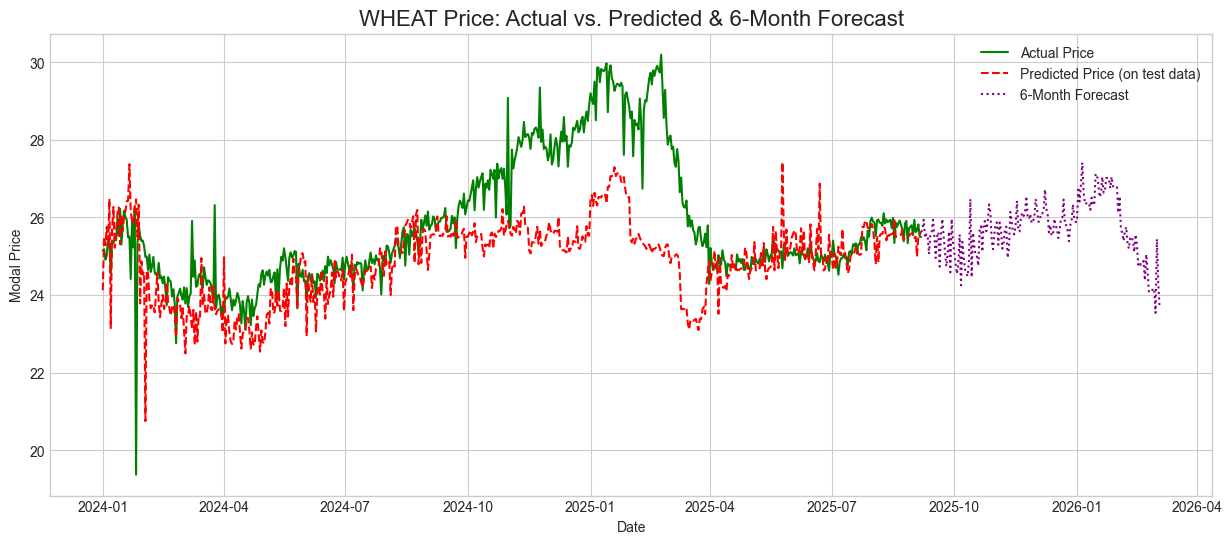

             forecast
2025-09-06  25.623678
2025-09-07  25.678062
2025-09-08  25.943136
2025-09-09  25.475594
2025-09-10  25.565777
...               ...
2026-02-28  24.161421
2026-03-01  23.539938
2026-03-02  25.443295
2026-03-03  24.310669
2026-03-04  23.664227

[180 rows x 1 columns]


In [18]:

predictor = CommodityPricePredictor(df_final)

predictor.train('WHEAT')

last_date = df_final.index.max() 
forecast_data = predictor.forecast_six_months('WHEAT', last_date)
print(forecast_data)

✅ Predictor initialized.
--- Training model for: RICE ---
Training data from 2021-03-08 to 2023-12-29
Testing data from 2024-01-03 to 2025-09-06
✅ Model for RICE trained and stored.

--- Evaluation Results for RICE ---
R-squared (R²): -0.541
Mean Absolute Error (MAE): 9.30
--------------------------------------


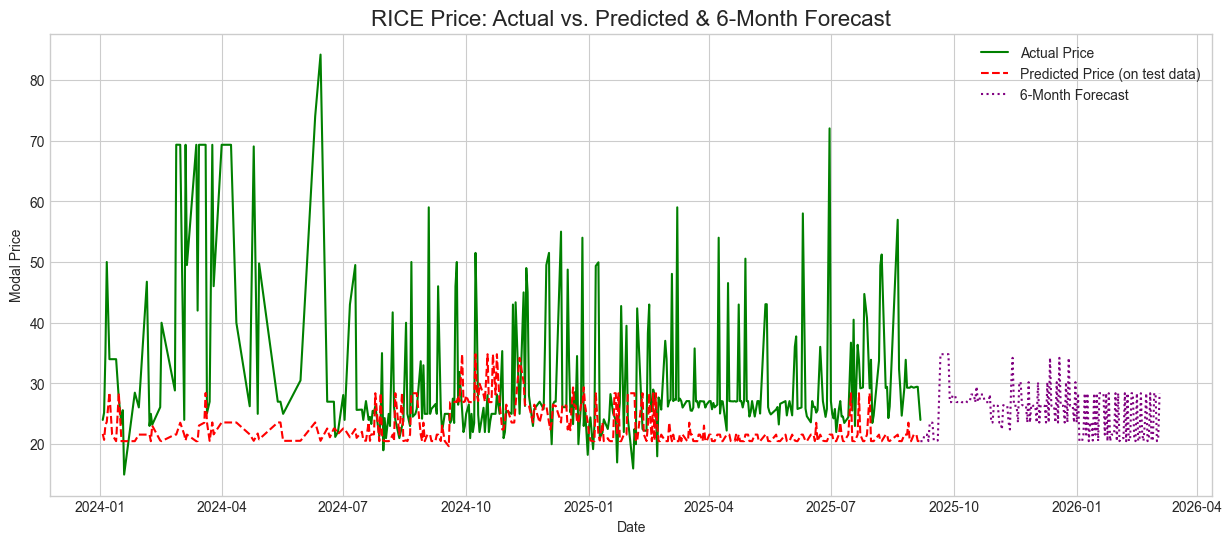

             forecast
2025-09-06  20.502869
2025-09-07  20.502869
2025-09-08  20.502869
2025-09-09  21.581985
2025-09-10  21.581985
...               ...
2026-02-28  28.394432
2026-03-01  28.394432
2026-03-02  20.502869
2026-03-03  20.995970
2026-03-04  28.394432

[180 rows x 1 columns]


In [19]:

predictor = CommodityPricePredictor(df_final)

predictor.train('RICE')

last_date = df_final.index.max() 
forecast_data = predictor.forecast_six_months('RICE', last_date)
print(forecast_data)

✅ Predictor initialized.
--- Training model for: WHEAT ---
Training data from 2021-01-31 to 2023-12-31
Testing data from 2024-01-01 to 2025-09-06
✅ Model for WHEAT trained and stored.

--- Evaluation Results for WHEAT ---
R-squared (R²): 0.065
Mean Absolute Error (MAE): 1.10
--------------------------------------


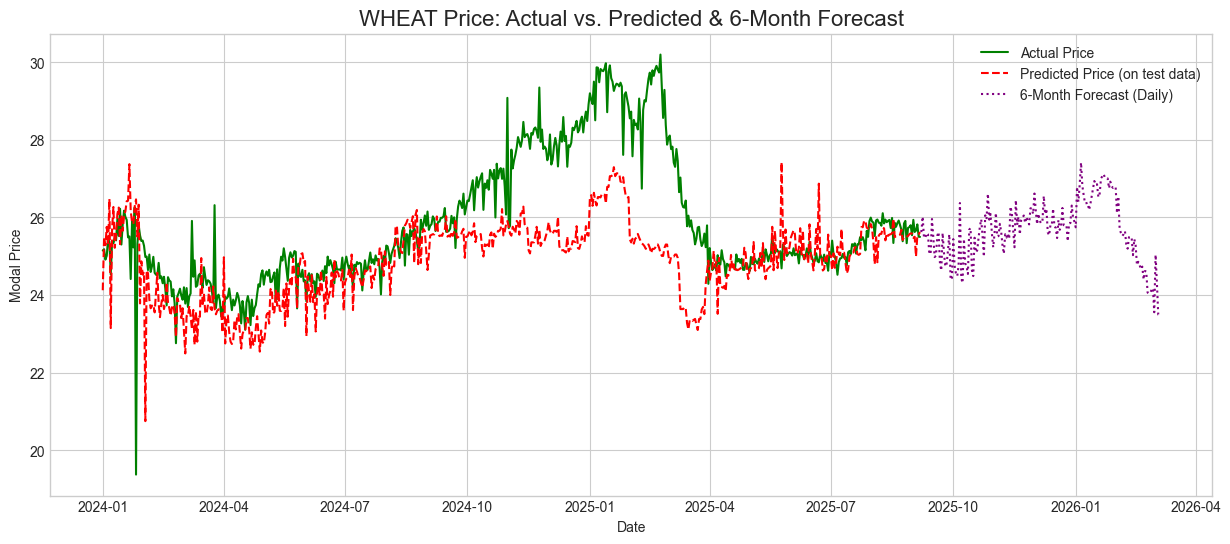


--- 6-Month Forecast for WHEAT (End of Month Price) ---
            forecast
2025-09-30     24.41
2025-10-31     25.23
2025-11-30     26.09
2025-12-31     25.89
2026-01-31     26.78
2026-02-28     24.18
---------------------------------------------------------


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

class CommodityPricePredictor:
    def __init__(self, df):
        if not isinstance(df.index, pd.DatetimeIndex):
            try:
                df['created_at'] = pd.to_datetime(df['created_at'])
                df = df.set_index('created_at')
            except (KeyError, TypeError):
                 raise TypeError("DataFrame must have a DatetimeIndex or a 'created_at' column to convert.")
        self.df_full = df.copy().sort_index()
        self.models = {} # to store a trained model for each commodity
        print("✅ Predictor initialized.")

    def _create_features(self, df):
        
        df = df.copy()
        df['dayofweek'] = df.index.dayofweek
        df['dayofyear'] = df.index.dayofyear
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['weekofyear'] = df.index.isocalendar().week.astype(int)

        # Lag features (price from previous periods)
        df['price_lag_7'] = df['modal_price'].shift(7)
        df['price_lag_14'] = df['modal_price'].shift(14)
        df['price_lag_30'] = df['modal_price'].shift(30)

        # Rolling window features (trend over the last month)
        df['rolling_mean_30'] = df['modal_price'].shift(1).rolling(window=30).mean()
        df['rolling_std_30'] = df['modal_price'].shift(1).rolling(window=30).std()

        return df.dropna()

    def train(self, commodity):
        """
        Trains a new XGBoost model for a specific commodity.
        """
        print(f"--- Training model for: {commodity} ---")

        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        if df_commodity.empty:
            print(f"⚠️ Warning: No data found for {commodity}. Skipping training.")
            return

        df_daily = df_commodity.groupby(df_commodity.index).agg({
            'modal_price': 'mean' # Use the average price for that day
        })

        df_featured = self._create_features(df_daily)

        train_df = df_featured.loc[df_featured.index < '2024-01-01']
        test_df = df_featured.loc[df_featured.index >= '2024-01-01']

        if test_df.empty or train_df.empty:
            print(f"⚠️ Warning: Not enough data to perform train/test split for {commodity}.")
            return

        print(f"Training data from {train_df.index.min().date()} to {train_df.index.max().date()}")
        print(f"Testing data from {test_df.index.min().date()} to {test_df.index.max().date()}")

        FEATURES = [col for col in df_featured.columns if col != 'modal_price']
        TARGET = 'modal_price'

        X_train, y_train = train_df[FEATURES], train_df[TARGET]
        X_test, y_test = test_df[FEATURES], test_df[TARGET]

        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            eval_metric='mae',
            early_stopping_rounds=20
        )

        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)

        self.models[commodity] = model
        print(f"✅ Model for {commodity} trained and stored.")
        self.evaluate(commodity, test_df) # Evaluate right after training

    def evaluate(self, commodity, test_df):
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found. Please train it first.")
            return

        model = self.models[commodity]
        FEATURES = [col for col in test_df.columns if col != 'modal_price']
        TARGET = 'modal_price'

        X_test, y_test = test_df[FEATURES], test_df[TARGET]
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        print(f"\n--- Evaluation Results for {commodity} ---")
        print(f"R-squared (R²): {r2:.3f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print("--------------------------------------")

        daily_forecast_df, monthly_forecast_df = self.forecast_six_months(commodity, test_df.index.max())

        plt.figure(figsize=(15, 6))
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.plot(y_test.index, y_test, label='Actual Price', color='green')
        plt.plot(y_test.index, predictions, label='Predicted Price (on test data)', color='red', linestyle='--')
        
        if daily_forecast_df is not None and not daily_forecast_df.empty:
            plt.plot(daily_forecast_df.index, daily_forecast_df['forecast'], 
                     label='6-Month Forecast (Daily)', color='purple', linestyle=':')
        
        plt.title(f'{commodity} Price: Actual vs. Predicted & 6-Month Forecast', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Modal Price')
        plt.legend()
        plt.show()
        
        if monthly_forecast_df is not None and not monthly_forecast_df.empty:
            print(f"\n--- 6-Month Forecast for {commodity} (End of Month Price) ---")
            print(monthly_forecast_df.to_string(float_format="%.2f"))
            print("---------------------------------------------------------")


    def forecast_six_months(self, commodity, last_known_date):
        
        if commodity not in self.models:
            print(f"❌ Error: Model for {commodity} not found.")
            return None, None

        model = self.models[commodity]
        df_commodity = self.df_full[self.df_full['commodity'] == commodity]
        df_daily = df_commodity.groupby(df_commodity.index).agg({'modal_price': 'mean'})
        
        future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=180, freq='D')
        future_df = pd.DataFrame(index=future_dates, columns=['modal_price'])
        df_extended = pd.concat([df_daily, future_df])
        
        for date in future_dates:
            featured_row = self._create_features(df_extended.loc[:date]).iloc[-1:]
            FEATURES = [col for col in featured_row.columns if col != 'modal_price']
            prediction = model.predict(featured_row[FEATURES])[0]
            df_extended.loc[date, 'modal_price'] = prediction
        
        daily_forecast_df = df_extended.loc[future_dates].copy()
        daily_forecast_df.rename(columns={'modal_price': 'forecast'}, inplace=True)
        monthly_forecast_df = daily_forecast_df.resample('ME').last().head(6)
        return daily_forecast_df, monthly_forecast_df


    
predictor = CommodityPricePredictor(df_final)
predictor.train('WHEAT')



In [ ]:
predictor = CommodityPricePredictor(df_final)

predictor.train('TOMATO')

# last_date = df_final.index.max() 
# forecast_data = predictor.forecast_six_months('RICE', last_date)
# print(forecast_data)

✅ Predictor initialized.
--- Training model for: TOMATO ---
Training data from 2021-01-31 to 2023-12-31
Testing data from 2024-01-01 to 2025-09-06
